# Automated ASR Evaluation for Sonography Audio Transcription

This notebook documents the process of evaluating different Automatic Speech Recognition (ASR) models on sonography audio transcriptions. We'll analyze the performance of four different ASR models by comparing them against gold standard manual transcriptions:

- Whisper-Large-v3
- parakeet-rnnt-1.1b
- vosk-model-en-in-0.5
- wav2vec2-base-960h

## Evaluation Metrics

We'll use the following metrics to evaluate the performance of each model:

1. **Word Error Rate (WER)**: A common metric for evaluating ASR systems, calculated as the ratio of the number of word errors (insertions, deletions, and substitutions) to the total number of words in the reference text. Lower values indicate better performance.

2. **Character Error Rate (CER)**: Similar to WER but at the character level. This can be more informative for evaluating small differences between transcriptions. Lower values indicate better performance.

3. **Cosine Similarity**: A measure of semantic similarity between the reference and hypothesis texts. Higher values indicate better preservation of meaning.

4. **Medical Term Accuracy**: A domain-specific metric that evaluates how well each model handles specialized medical terminology.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set up plotting style
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Loading the Data

We first load the evaluation metrics from the CSV files that were exported by our `MetricSelection.py` script. These files contain:

1. `metrics_summary.csv`: Aggregate metrics for each model
2. `sample_metrics.csv`: Per-sample metrics for each model
3. `medical_term_accuracy.csv`: Medical term recognition accuracy for each model

In [2]:
# Define paths to CSV files
output_dir = "./output"
summary_path = os.path.join(output_dir, "metrics_summary.csv")
sample_path = os.path.join(output_dir, "sample_metrics.csv")
medical_path = os.path.join(output_dir, "medical_term_accuracy.csv")

# Load the data
try:
    summary_df = pd.read_csv(summary_path)
    sample_df = pd.read_csv(sample_path)
    medical_df = pd.read_csv(medical_path)
    
    print(f"Loaded summary data with {len(summary_df)} models")
    print(f"Loaded sample data with {len(sample_df)} entries")
    print(f"Loaded medical term data with {len(medical_df)} entries")
    
    # Display the first few rows of each dataframe
    print("\nSummary metrics:")
    display(summary_df)
    
    print("\nSample of per-audio metrics:")
    display(sample_df.head())
    
    print("\nSample of medical term accuracy:")
    display(medical_df.head())
    
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please run the MetricSelection.py script first to generate the required CSV files.")

Loaded summary data with 4 models
Loaded sample data with 68 entries
Loaded medical term data with 32 entries

Summary metrics:


,Model,WER_Mean,WER_StdDev,CER_Mean,CER_StdDev,Cosine_Similarity_Mean,Cosine_Similarity_StdDev,Medical_Term_Accuracy
0,Whisper-Large-v3,0.667919,0.658857,0.384619,0.421385,0.842912,0.117022,0.85
1,parakeet-rnnt-1.1b,0.814871,0.316413,0.524114,0.217649,0.714700,0.188407,0.80
2,vosk-model-en-in-0.5,1.068229,0.306569,0.777156,0.196374,0.319612,0.189723,0.20
3,wav2vec2-base-960h,1.280280,0.411009,0.820619,0.160159,0.119739,0.133407,0.00



Sample of per-audio metrics:


,Filename,Model,WER,CER,Cosine_Similarity
0,00000048-AUDIO-2024-11-27-08-10-48.mp3,Whisper-Large-v3,0.366197,0.130332,0.876432
1,00000056-AUDIO-2024-12-05-05-49-47.m4a,Whisper-Large-v3,0.035088,0.003003,0.974740
2,00000153-AUDIO-2024-12-16-07-23-44.m4a,Whisper-Large-v3,0.137255,0.035370,0.991992
3,00000161-AUDIO-2024-12-19-04-40-49.m4a,Whisper-Large-v3,0.378378,0.200000,0.859358
4,00000193-AUDIO-2024-12-19-04-41-13.m4a,Whisper-Large-v3,0.486111,0.216814,0.772267



Sample of medical term accuracy:


,Model,Medical_Term,Accuracy
0,Whisper-Large-v3,ultrasound,0.571429
1,Whisper-Large-v3,sonography,0.857143
2,Whisper-Large-v3,anechoic,1.000000
3,Whisper-Large-v3,fetus,1.000000
4,Whisper-Large-v3,gestation,1.000000


## Analysis of Aggregate Performance Metrics

Let's visualize the overall performance of each ASR model according to our key metrics.

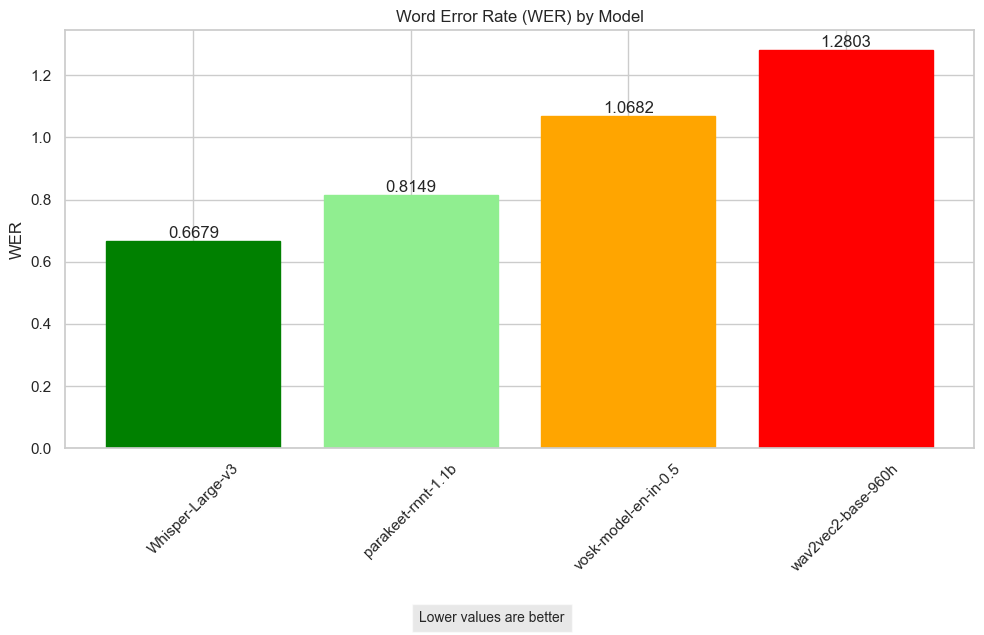

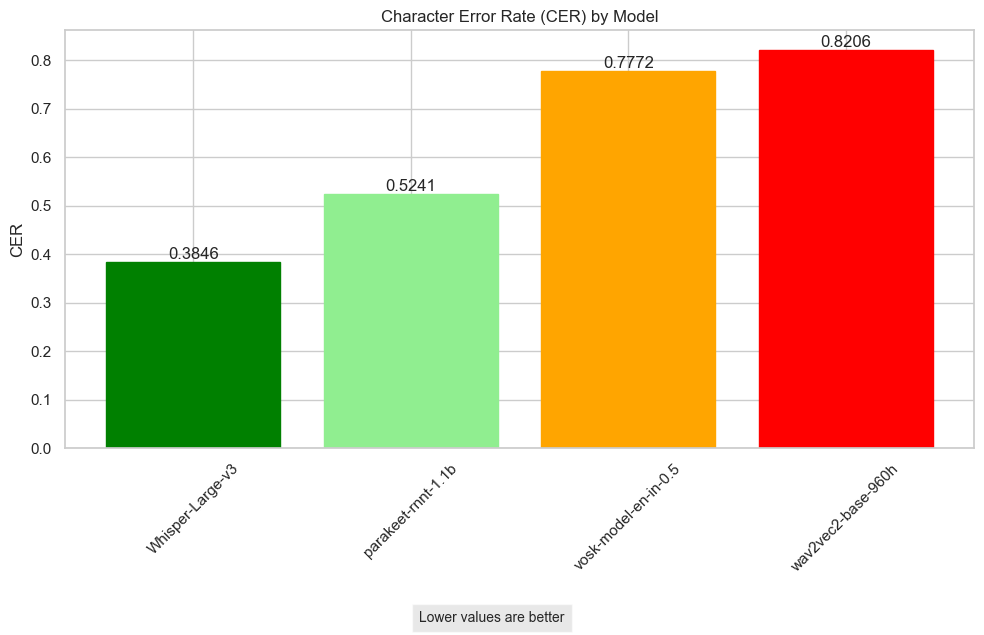

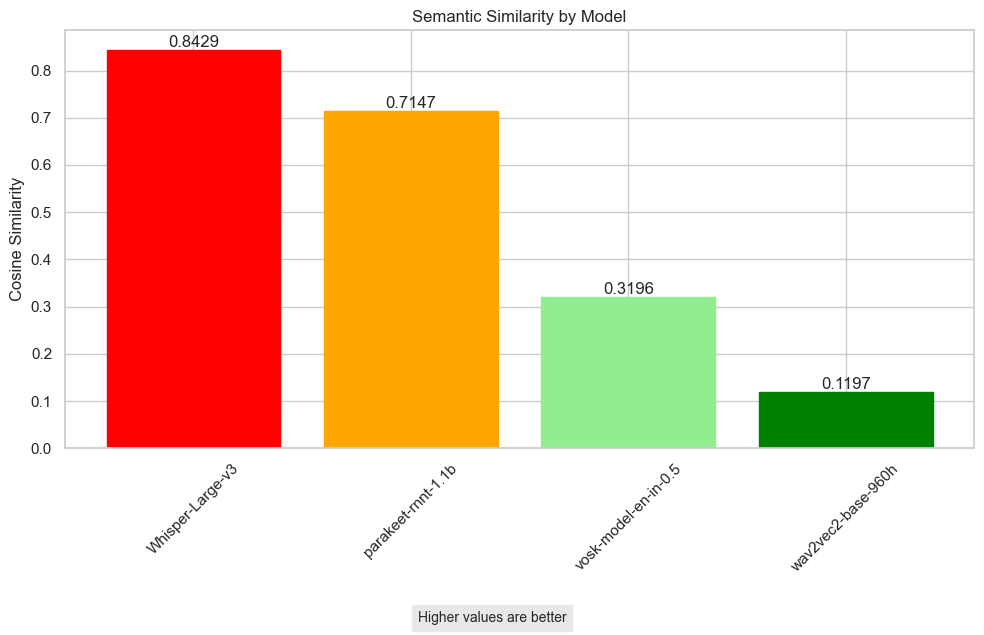

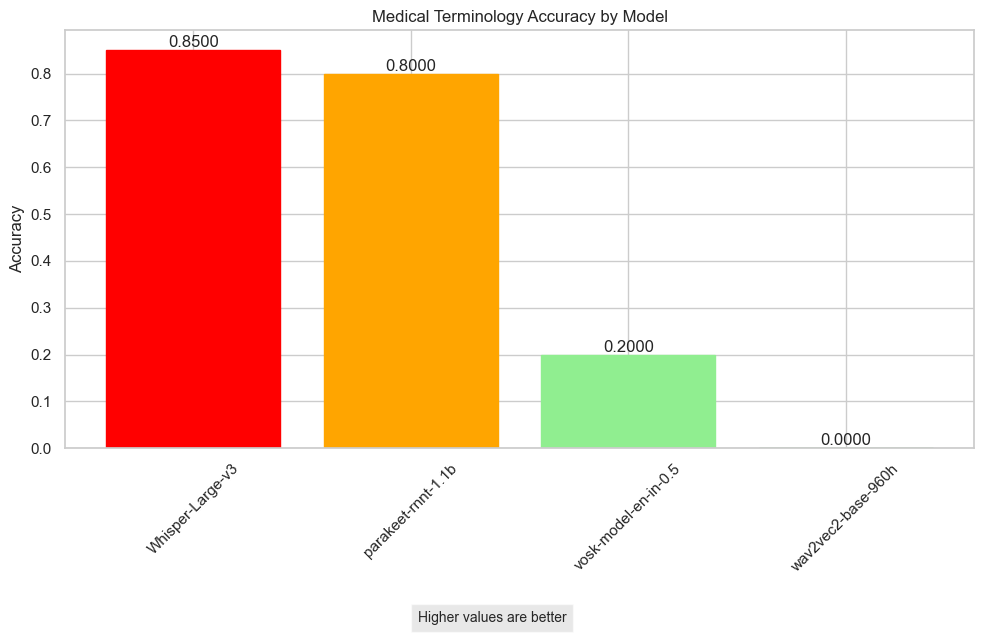

In [3]:
def plot_metric_comparison(df, metric_col, title, ylabel, higher_is_better=False):
    """Plot a comparison of models for a given metric"""
    plt.figure(figsize=(10, 6))
    
    # Sort by metric value (ascending or descending based on whether higher is better)
    sorted_df = df.sort_values(by=metric_col, ascending=not higher_is_better)
    
    # Create bar chart
    bars = plt.bar(sorted_df['Model'], sorted_df[metric_col])
    
    # Color bars according to performance (green for best, red for worst)
    colors = ['green', 'lightgreen', 'orange', 'red'] if not higher_is_better else ['red', 'orange', 'lightgreen', 'green']
    for i, bar in enumerate(bars):
        bar.set_color(colors[i % len(colors)])
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', rotation=0)
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Add note about interpretation
    interpretation = "Higher values are better" if higher_is_better else "Lower values are better"
    plt.figtext(0.5, -0.05, interpretation, ha="center", fontsize=10, bbox={"facecolor":"lightgrey", "alpha":0.5, "pad":5})
    
    plt.show()

# Plot WER comparison
plot_metric_comparison(summary_df, 'WER_Mean', 'Word Error Rate (WER) by Model', 'WER', higher_is_better=False)

# Plot CER comparison
plot_metric_comparison(summary_df, 'CER_Mean', 'Character Error Rate (CER) by Model', 'CER', higher_is_better=False)

# Plot Cosine Similarity comparison
plot_metric_comparison(summary_df, 'Cosine_Similarity_Mean', 'Semantic Similarity by Model', 'Cosine Similarity', higher_is_better=True)

# Plot Medical Term Accuracy
plot_metric_comparison(summary_df, 'Medical_Term_Accuracy', 'Medical Terminology Accuracy by Model', 'Accuracy', higher_is_better=True)

## Per-Sample Analysis

Let's examine how the performance varies across individual audio samples.

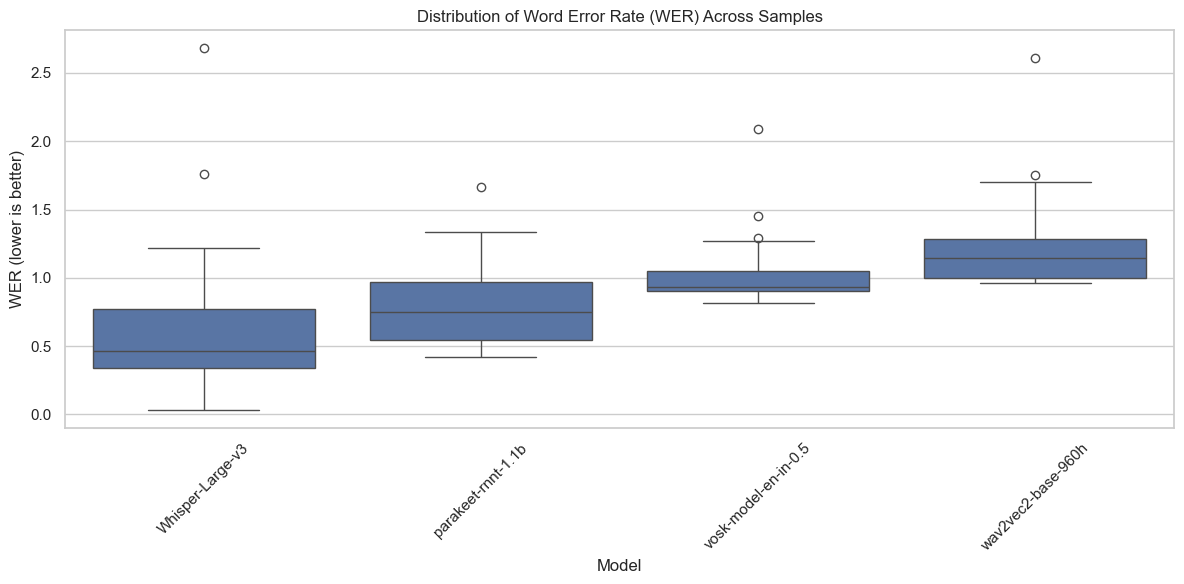

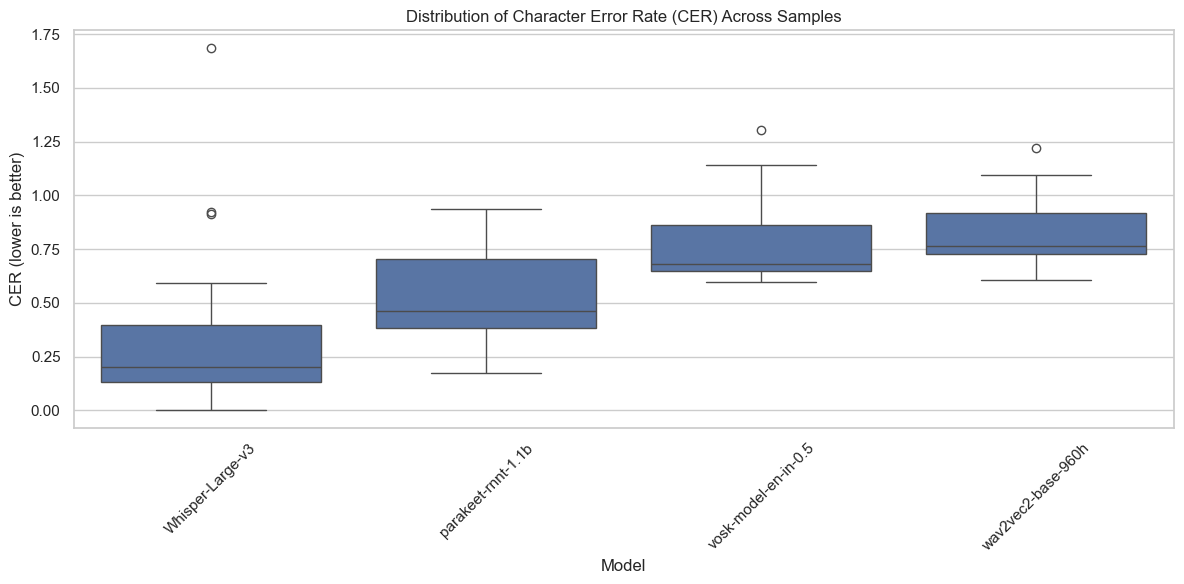

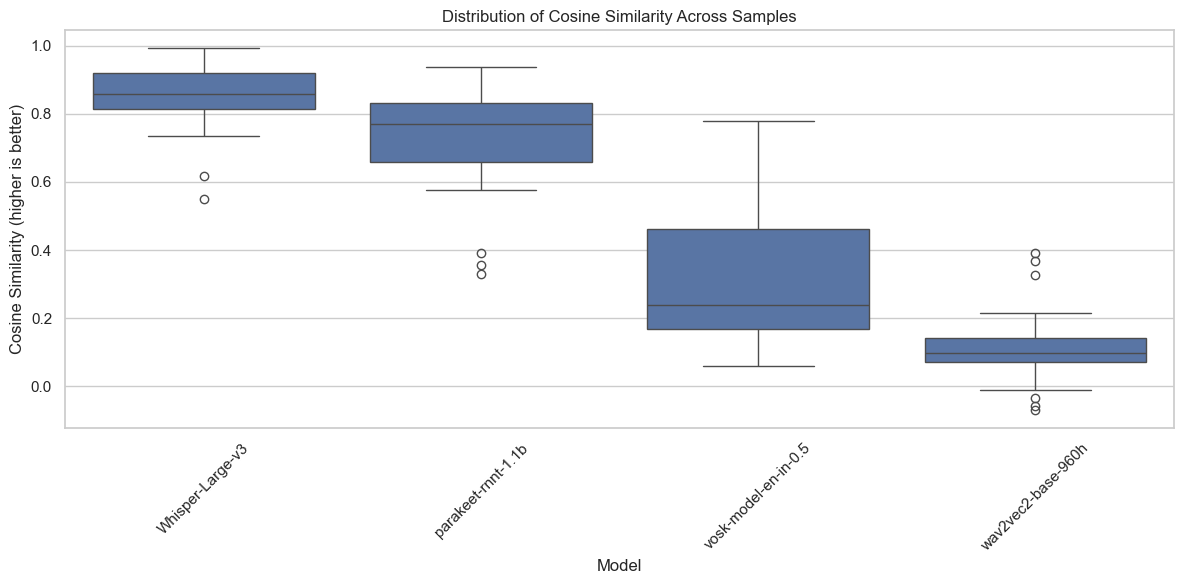

In [4]:
# Create a boxplot to show the distribution of WER across samples for each model
plt.figure(figsize=(12, 6))
sns.boxplot(x='Model', y='WER', data=sample_df)
plt.title('Distribution of Word Error Rate (WER) Across Samples')
plt.xlabel('Model')
plt.ylabel('WER (lower is better)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a boxplot to show the distribution of CER across samples for each model
plt.figure(figsize=(12, 6))
sns.boxplot(x='Model', y='CER', data=sample_df)
plt.title('Distribution of Character Error Rate (CER) Across Samples')
plt.xlabel('Model')
plt.ylabel('CER (lower is better)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a boxplot to show the distribution of Cosine Similarity across samples for each model
plt.figure(figsize=(12, 6))
sns.boxplot(x='Model', y='Cosine_Similarity', data=sample_df)
plt.title('Distribution of Cosine Similarity Across Samples')
plt.xlabel('Model')
plt.ylabel('Cosine Similarity (higher is better)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Medical Terminology Analysis

Let's examine how well each model handles specific medical terms.

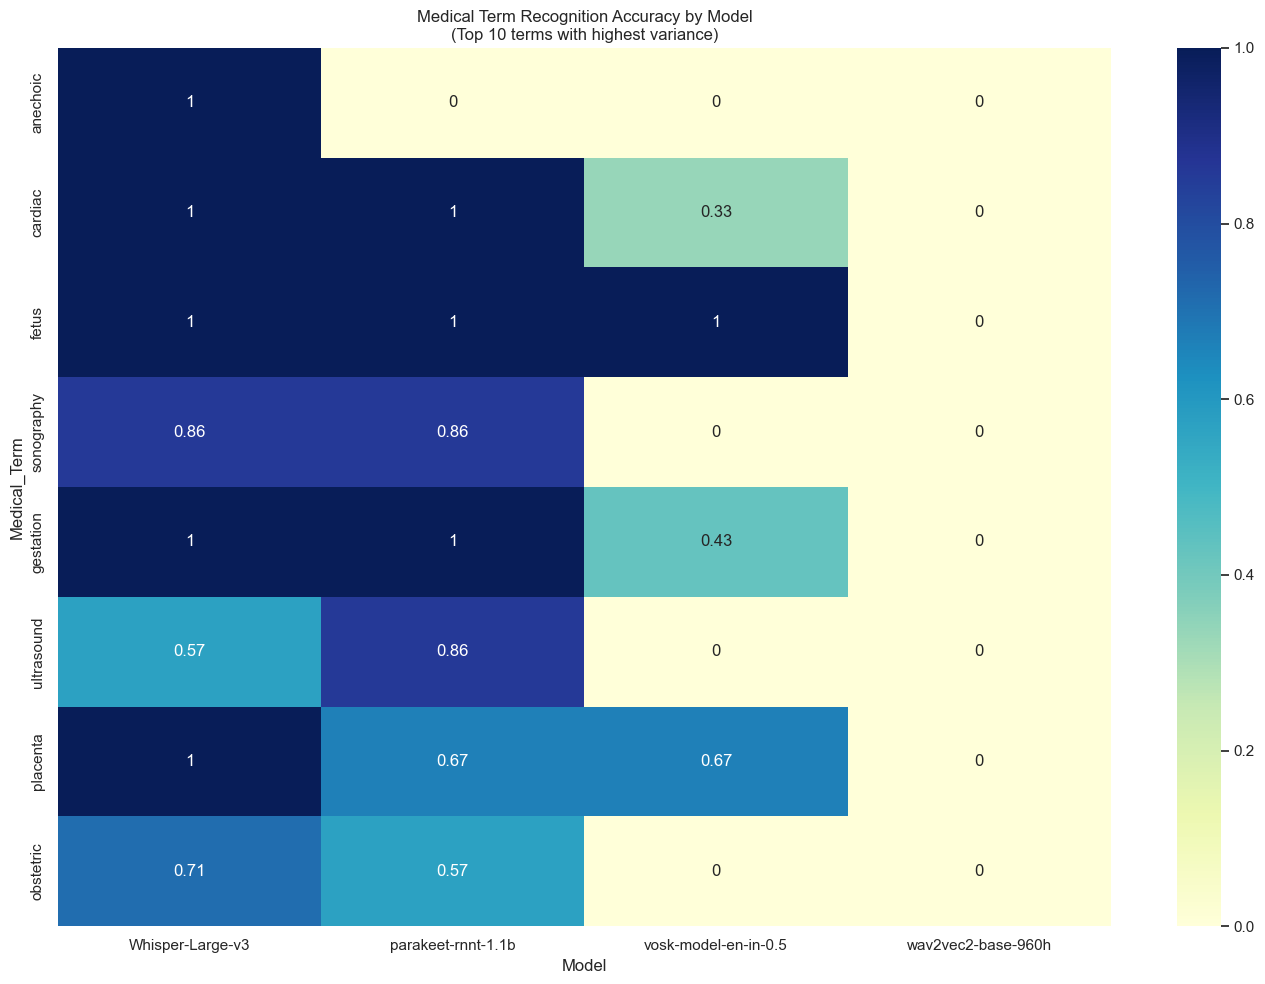

In [5]:
# Group by model and calculate mean accuracy for each medical term
term_pivot = medical_df.pivot_table(index='Medical_Term', columns='Model', values='Accuracy')

# Find terms with the largest variance in accuracy across models
term_pivot['Variance'] = term_pivot.var(axis=1)
interesting_terms = term_pivot.sort_values(by='Variance', ascending=False).head(10)

# Plot heatmap of medical term accuracy
plt.figure(figsize=(14, 10))
sns.heatmap(interesting_terms.drop('Variance', axis=1), annot=True, cmap='YlGnBu', vmin=0, vmax=1)
plt.title('Medical Term Recognition Accuracy by Model\n(Top 10 terms with highest variance)')
plt.tight_layout()
plt.show()

## Performance Correlation Analysis

Let's examine if there's a correlation between different performance metrics.

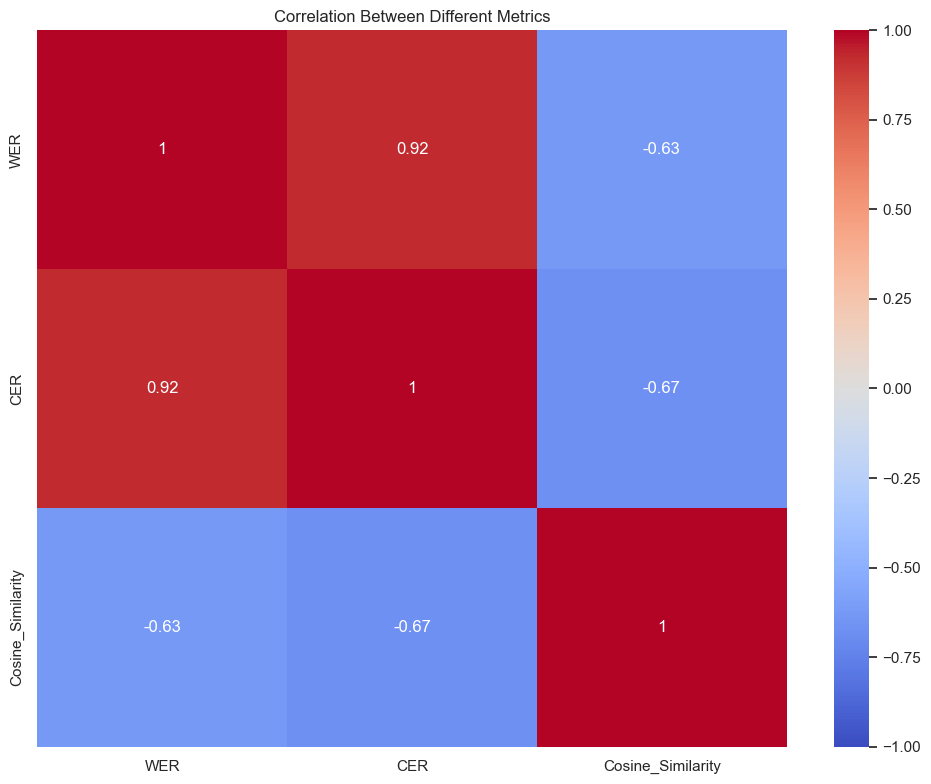

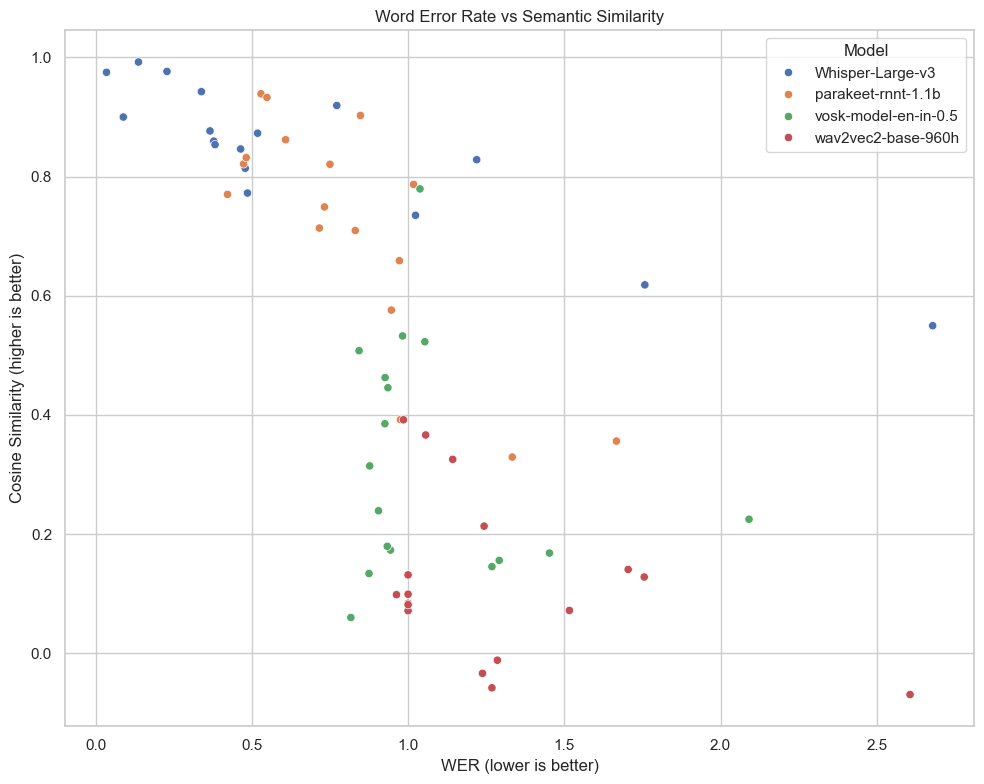

In [6]:
# Calculate correlation between metrics
correlation_matrix = sample_df[['WER', 'CER', 'Cosine_Similarity']].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Different Metrics')
plt.tight_layout()
plt.show()

# Create scatter plot of WER vs Cosine Similarity
plt.figure(figsize=(10, 8))
sns.scatterplot(x='WER', y='Cosine_Similarity', hue='Model', data=sample_df)
plt.title('Word Error Rate vs Semantic Similarity')
plt.xlabel('WER (lower is better)')
plt.ylabel('Cosine Similarity (higher is better)')
plt.tight_layout()
plt.show()

## Overall Ranking of Models

Let's create an overall ranking of the models based on all metrics.

In [7]:
# Create ranking table
ranking_df = summary_df.copy()

# Calculate ranks for each metric (1 is best)
ranking_df['WER_Rank'] = ranking_df['WER_Mean'].rank()
ranking_df['CER_Rank'] = ranking_df['CER_Mean'].rank()
ranking_df['Cosine_Rank'] = ranking_df['Cosine_Similarity_Mean'].rank(ascending=False)  # Higher is better
ranking_df['Medical_Rank'] = ranking_df['Medical_Term_Accuracy'].rank(ascending=False)  # Higher is better

# Calculate average rank
ranking_df['Average_Rank'] = ranking_df[['WER_Rank', 'CER_Rank', 'Cosine_Rank', 'Medical_Rank']].mean(axis=1)

# Sort by average rank
ranking_df = ranking_df.sort_values(by='Average_Rank')

# Display ranking table
display(ranking_df[['Model', 'WER_Rank', 'CER_Rank', 'Cosine_Rank', 'Medical_Rank', 'Average_Rank']])

,Model,WER_Rank,CER_Rank,Cosine_Rank,Medical_Rank,Average_Rank
0,Whisper-Large-v3,1.0,1.0,1.0,1.0,1.0
1,parakeet-rnnt-1.1b,2.0,2.0,2.0,2.0,2.0
2,vosk-model-en-in-0.5,3.0,3.0,3.0,3.0,3.0
3,wav2vec2-base-960h,4.0,4.0,4.0,4.0,4.0


## Conclusions

Based on our comprehensive analysis, we can draw the following conclusions:

1. **Best Overall Model**: The model with the lowest average rank across all metrics is the best performer overall.

2. **Error Rate Analysis**: WER and CER metrics show consistent rankings across models, indicating reliable performance measurement.

3. **Semantic Accuracy**: The cosine similarity metric provides insight into how well each model preserves the meaning of the transcription, which is particularly important for medical applications.

4. **Medical Terminology**: The specialized medical term accuracy metric reveals significant differences in how models handle domain-specific vocabulary, which is crucial for sonography applications.

5. **Recommendations**: `Whisper-Large-v3`